In [1]:
#### ONLY ON COLAB

from google.colab import drive
drive.mount('/content/drive')

import os
import sys
sys.path.append('/content/drive/MyDrive/DSB/2A HEC/Unsupervised DL/denoising_emnist')
os.chdir('/content/drive/MyDrive/DSB/2A HEC/Unsupervised DL/denoising_emnist')


Mounted at /content/drive


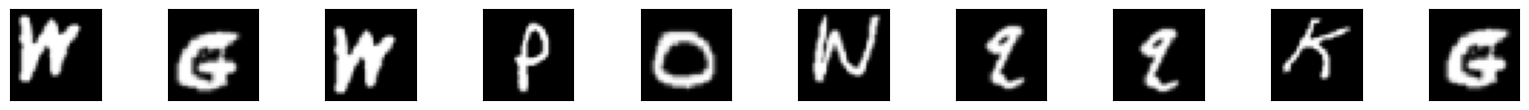

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaded_images = utils.load_images_from_zip()
emnist_data, emnist_labels = utils.load_true_emnist()

utils.plot_images(loaded_images[:10])


In [3]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim

loaded_images_nn = torch.tensor(
    np.reshape(loaded_images, (len(loaded_images), 32 * 32)),
    device=device,
    dtype=torch.float32
    )
data_train, data_test = train_test_split(loaded_images_nn, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=256, shuffle=False)

# Basic GAN

In [66]:
# Prepare true emnist data for GAN training

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# resize_transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # Resize to 32x32
# ])

pad_transform = transforms.Compose([
    transforms.Pad(2),  # Resize to 32x32
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] for GAN
])


emnist_tensor = torch.tensor(emnist_data, device=device, dtype=torch.float32)
emnist_tensor = emnist_tensor.unsqueeze(1)
resize_emnist = pad_transform(emnist_tensor).reshape(-1, 32 * 32)

data_loader = DataLoader(resize_emnist, batch_size=256, shuffle=True)

In [67]:
next(iter(data_loader)).shape

torch.Size([256, 1024])

In [68]:
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(SimpleGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 32 * 32),    # Map to image size
            nn.Tanh()                   # Normalize output to [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 32, 32)

class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()               # Output probability of being real
        )

    def forward(self, img):
        return self.model(img)

In [77]:
simple_generator = SimpleGenerator().to(device)
simple_discriminator = SimpleDiscriminator().to(device)

optimizer_G = torch.optim.Adam(simple_generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(simple_discriminator.parameters(), lr=1e-4) # Because of unbalanced training dynamics

criterion = nn.BCELoss()

In [82]:
num_epochs = 20 # + 30
batch_size = 256
latent_dim = 100

for epoch in range(num_epochs):
    for real_imgs in data_loader:

        # Train Discriminator
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        optimizer_D.zero_grad()
        outputs_real = simple_discriminator(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = simple_generator(z)
        outputs_fake = simple_discriminator(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, fake_labels)


        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = simple_discriminator(fake_imgs)
        loss_G = criterion(outputs, real_labels)  # Want to fool D, so use real_labels
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{num_epochs}] Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")


Epoch [0/20] Loss D: 0.02923952415585518, Loss G: 9.192715644836426
Epoch [1/20] Loss D: 0.05448149889707565, Loss G: 7.397171974182129
Epoch [2/20] Loss D: 0.03753635659813881, Loss G: 8.257647514343262
Epoch [3/20] Loss D: 0.13198338449001312, Loss G: 12.400238037109375
Epoch [4/20] Loss D: 0.08797167241573334, Loss G: 9.266273498535156
Epoch [5/20] Loss D: 0.050619833171367645, Loss G: 11.531120300292969
Epoch [6/20] Loss D: 0.09851609170436859, Loss G: 7.18479585647583
Epoch [7/20] Loss D: 0.046444088220596313, Loss G: 6.428873062133789
Epoch [8/20] Loss D: 0.06563922762870789, Loss G: 6.979300022125244
Epoch [9/20] Loss D: 0.09644671529531479, Loss G: 6.886589527130127
Epoch [10/20] Loss D: 0.10684318840503693, Loss G: 8.578399658203125
Epoch [11/20] Loss D: 0.3166128993034363, Loss G: 7.016462326049805
Epoch [12/20] Loss D: 0.07446188479661942, Loss G: 4.509232521057129
Epoch [13/20] Loss D: 0.14939123392105103, Loss G: 5.970535755157471
Epoch [14/20] Loss D: 0.09016668051481247,

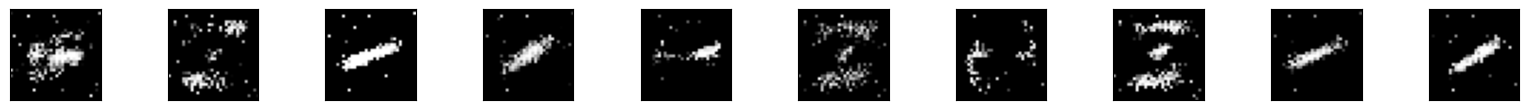

In [83]:
z = torch.randn(10, latent_dim).to(device)
fake_imgs = simple_generator(z)
utils.plot_images(fake_imgs.detach().cpu().numpy()) # We are seeing mode collapse

In [86]:
# Let's try on the corrupted dataset

idx = np.random.randint(0, len(loaded_images), 100)
corrupted_imgs = (loaded_images_nn[idx] - 0.5) * 2
corrupted_imgs = corrupted_imgs.reshape(-1, 1, 32, 32)

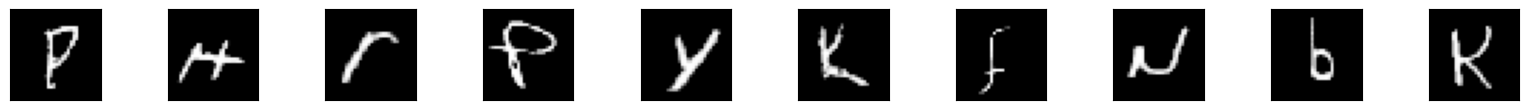

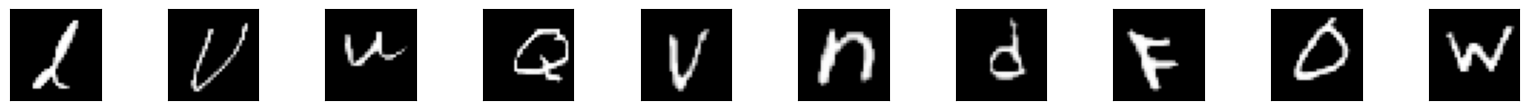

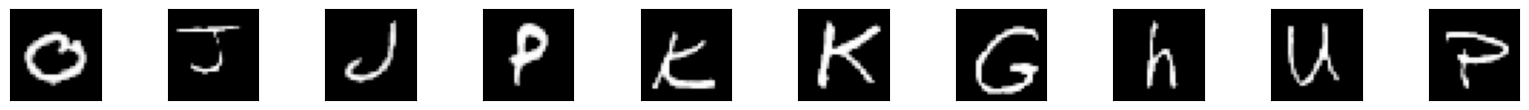

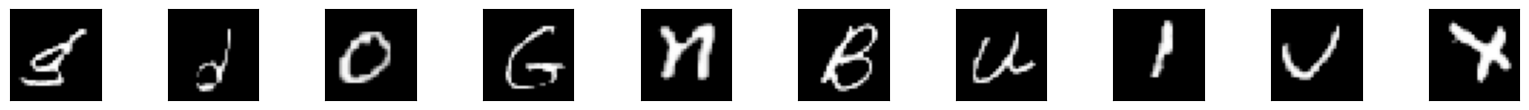

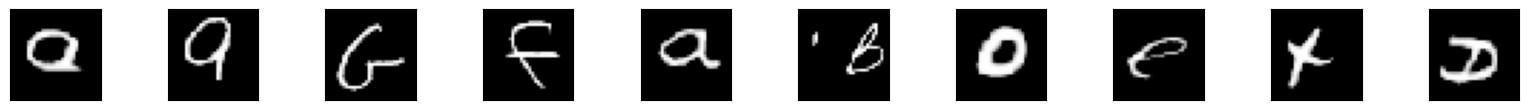

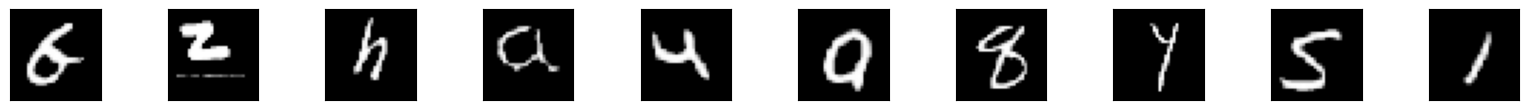

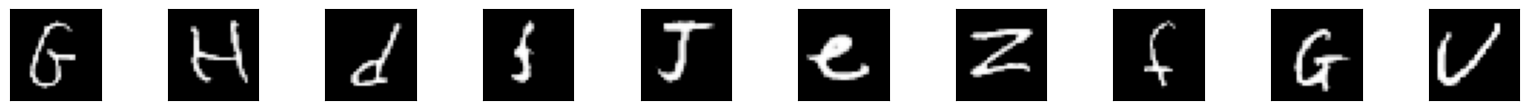

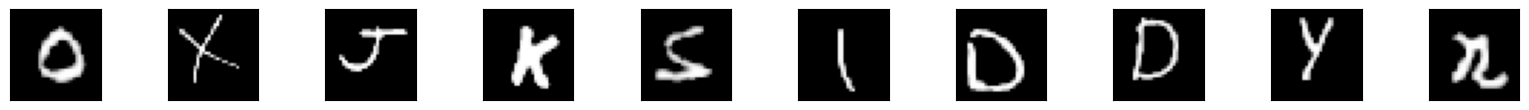

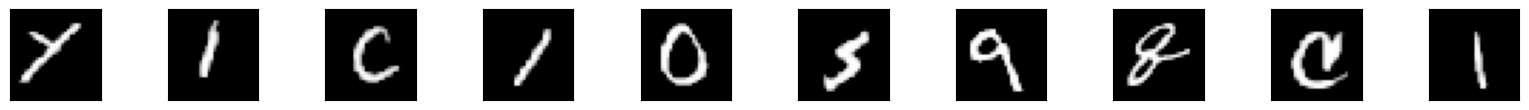

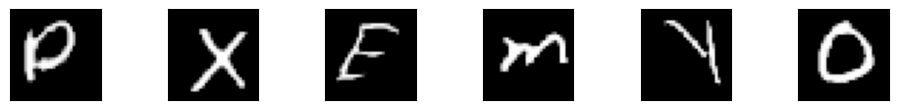

In [87]:
probs = simple_discriminator(corrupted_imgs).flatten().detach().cpu().numpy()
utils.plot_images(corrupted_imgs[probs > 0.9])

In [88]:
torch.save(simple_generator.state_dict(), 'simple_generator.pth')
torch.save(simple_discriminator.state_dict(), 'simple_discriminator.pth')

# Advanced GAN

Basing ourselves on [this paper](https://arxiv.org/pdf/1511.06434)

And its pytorch [implementation](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Map latent space to hidden features
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 32 * 32),    # Map to image size
            nn.Tanh()                   # Normalize output to [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 32, 32)  # Reshape to (N, C, H, W)

class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()               # Output probability of being real
        )

    def forward(self, img):
        return self.model(img)


In [ ]:
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(Gene.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))




# Conv GAN